In [1]:
import os
import glob
import zipfile
import concurrent.futures
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## This code reads multiple zip files that contain multiple CSV files of sensor data, extracts the required data from them, and combines them into a single pandas DataFrame. The extracted data includes ACC, BVP, EDA, HR, IBI, and TEMP. The extract_data function takes in a list of zip file names, iterates through the files, and for each file, extracts the required data and renames the columns. The extracted data is then joined to create a single DataFrame. The function returns this DataFrame after dropping any rows that contain missing values. The main part of the code uses the glob module to get a list of all the folders that contain the zip files. It then iterates over these folders and extracts data from all the zip files in each folder using the extract_data function. The resulting DataFrames are concatenated into a single DataFrame, and any rows with temporary IBI values are dropped. The resulting DataFrame is returned.

In [2]:
import pandas as pd
import glob
import os
import zipfile

def extract_data(files):
    joined_list = []
    for file in files:
        with zipfile.ZipFile(file) as zf:
            zf.extractall()
            sensor_coords = pd.read_csv('ACC.csv', index_col=None, header=0)
            BVP = pd.read_csv('BVP.csv', index_col=None, header=0)
            eda = pd.read_csv('EDA.csv', index_col=None, header=0)
            heart_rates = pd.read_csv('HR.csv', index_col=None, header=0)
            ibi = pd.read_csv('IBI.csv', index_col=None, header=0) if os.path.getsize('IBI.csv') > 0 else None
            temp = pd.read_csv('TEMP.csv', index_col=None, header=0)

            sensor_coords = sensor_coords.rename(columns={sensor_coords.columns[0]: 'X_AXIS', sensor_coords.columns[1]: 'Y_AXIS', sensor_coords.columns[2]: 'Z_AXIS'})
            BVP = BVP.rename(columns={BVP.columns[0]: 'BVP'})
            eda = eda.rename(columns={eda.columns[0]: 'EDA'})
            heart_rates = heart_rates.rename(columns={heart_rates.columns[0]: 'HR'})
            if ibi is not None:
                ibi = ibi.rename(columns={ibi.columns[0]: 'IBI', ibi.columns[1]: 'IBI_TWO'})
            
            temp = temp.rename(columns={temp.columns[0]: 'TEMP'})

            if ibi is not None:
                joined = sensor_coords.join(BVP).join(eda).join(heart_rates).join(ibi).join(temp).dropna()
            else:
                joined = sensor_coords.join(BVP).join(eda).join(heart_rates).dropna()
                joined['IBI'] = 'Temporary'
                joined['IBI_TWO'] = 'Temporary'
                joined = joined.join(temp)

            joined_list.append(joined)

    df = pd.concat(joined_list).reset_index(drop=True)
    df = df[~(df['IBI'] == 'Temporary')]
    return df

folders = glob.glob(os.path.join("Data/*"))
df = pd.concat([extract_data(glob.glob(os.path.join(folder, '*.zip'))) for folder in folders]).reset_index(drop=True)

In [5]:
# Removing Unnamed column from the dataset
df = pd.read_csv('processed.csv')
df = df.drop('Unnamed: 0', axis=1)
df

,X,Y,Z,BVP,EDA,HR,INITIAL,INTERVAL,TEMP
0,32.0,32.0,32.0,64.00,4.000000,1.00,109.312500,0.6875,4.00
1,-57.0,7.0,-31.0,-0.00,0.000000,83.00,110.015625,0.703125,30.13
2,-57.0,7.0,-30.0,-0.00,0.032035,83.00,110.718750,0.703125,30.13
3,-57.0,7.0,-30.0,-0.00,0.060226,83.67,111.421875,0.703125,30.13
4,-57.0,7.0,-31.0,-0.00,0.067915,87.25,112.140625,0.71875,30.13
...,...,...,...,...,...,...,...,...,...
815936,-3.0,20.0,54.0,83.42,0.158789,100.82,7256.296875,0.546875,33.39
815937,-77.0,23.0,53.0,64.25,0.157509,100.73,7256.828125,0.53125,33.39
815938,-55.0,14.0,56.0,31.21,0.156228,100.67,7257.375000,0.546875,33.39
815939,-29.0,17.0,50.0,-10.26,0.157509,100.62,7292.140625,0.5625,33.39


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815941 entries, 0 to 815940
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   X         815941 non-null  float64
 1   Y         815941 non-null  float64
 2   Z         815941 non-null  float64
 3   BVP       815941 non-null  float64
 4   EDA       815941 non-null  float64
 5   HR        815941 non-null  float64
 6   INITIAL   815941 non-null  float64
 7   INTERVAL  815941 non-null  object 
 8   TEMP      815941 non-null  float64
dtypes: float64(8), object(1)
memory usage: 56.0+ MB


## This code is performing two operations on a pandas DataFrame called df. The first operation is filtering out rows where the value in the INTERVAL column is equal to the string ' IBI'. The tilde (~) operator is used to negate the Boolean condition in the parentheses, so that the resulting DataFrame includes only the rows where the condition is False. The second operation is converting the INTERVAL column from an object (presumably a string) to a float data type. The .astype() method is used to change the data type of the column to float. Overall, this code is cleaning the INTERVAL column of the df DataFrame by removing rows with a certain value, and then converting the remaining values to float data type.

In [9]:
# Converting object to float
df = df[~(df['INTERVAL'] == ' IBI')]
df['INTERVAL'] = df['INTERVAL'].astype(float)

In [12]:
df = df[~(df['INTERVAL'] == ' INTERVAL')]
df['INTERVAL'] = df['INTERVAL'].astype(float)

In [13]:
df.dtypes

X           float64
Y           float64
Z           float64
BVP         float64
EDA         float64
HR          float64
INITIAL     float64
INTERVAL    float64
TEMP        float64
dtype: object

In [14]:
# Statistics of the data
df.describe()

,X,Y,Z,BVP,EDA,HR,INITIAL,INTERVAL,TEMP
count,815939.000000,815939.000000,815939.000000,815939.000000,815939.000000,815939.000000,815939.000000,815939.000000,815939.000000
mean,-26.112974,-0.664389,26.236042,0.143793,0.902096,84.336610,9095.210078,0.764116,32.491756
std,33.588470,28.567795,31.324156,105.497682,1.892505,13.488803,8202.282849,0.134704,2.246957
min,-128.000000,-128.000000,-128.000000,-2460.680000,0.000000,1.000000,9.500000,0.312500,4.000000
25%,-54.000000,-13.000000,4.000000,-21.820000,0.091230,75.980000,2640.242188,0.671875,31.130000
50%,-30.000000,0.000000,32.000000,1.550000,0.304773,82.650000,6796.375000,0.750000,32.680000
75%,-11.000000,14.000000,54.000000,27.280000,0.793289,91.730000,13333.976562,0.828125,34.180000
max,127.000000,127.000000,127.000000,1601.140000,24.503405,184.220000,45961.546875,1.953125,37.430000


## This code calculates the 30th percentile (quantile) of three variables 'X', 'Y', and 'Z' in the DataFrame 'df' using the NumPy library's 'quantile' function. It then uses these quantiles to create a new column in 'df' called 'target' using the 'np.where' function. The 'target' column contains binary values, either 1 or 0, depending on whether the corresponding row values in 'X', 'Y', 'Z', 'BVP', and 'HR' are greater than the calculated quantiles. Specifically, if the value of 'X' is greater than the 'acc_quantile', the value of 'Y' is greater than the 'acc_quantile', the value of 'Z' is greater than the 'acc_quantile', the value of 'BVP' is greater than the 'bvp_quantile', and the value of 'HR' is greater than the 'hr_quantile', the corresponding value in the 'target' column will be set to 1; otherwise, it will be set to 0.

In [16]:
# This is use for labeling. According to paper i identify these columns and set the threshold to 30 percent. if values exceeds 30 percent then it will be 1 otherwise 0
import numpy as np

acc_quantile = np.quantile(df['X'], 0.30)
bvp_quantile = np.quantile(df['Y'], 0.30)
hr_quantile = np.quantile(df['Z'], 0.30)

df['target'] = np.where((df['X'] > acc_quantile) &
                          (df['Y'] > acc_quantile) &
                          (df['Z'] > acc_quantile) &
                          (df['BVP'] > bvp_quantile) &
                          (df['HR'] > hr_quantile), 1, 0)


## This code is performing downsampling on a Pandas DataFrame df which has a column named 'target'. First, it is creating two new DataFrames: df_Z which contains all rows from df where the value in the 'target' column is 0, and df_O which contains all rows where the value in the 'target' column is 1. Then, it is downsampling the df_Z DataFrame to a size of 327000 rows. It does this by randomly selecting 327000 rows from df_Z using the .sample() method. Finally, it is concatenating the downsampled df_Z DataFrame with the df_O DataFrame using the pd.concat() method with ignore_index=True. This creates a new DataFrame with the same columns as df, where the first 327000 rows are from df_Z and the remaining rows are from df_O. The resulting DataFrame is returned and may be used for further analysis or modeling. The purpose of this downsampling is likely to address class imbalance in the target variable, where there are many more rows with a target value of 0 than 1. By downsampling the majority class, the resulting DataFrame has a more balanced distribution of target values, which can improve model performance for certain types of models.

In [31]:
# Downsampling
df_Z = df[df['target'] == 0]
df_O = df[df['target'] == 1]

df_Z = df_Z.sample(327000)

df = pd.concat([df_Z,df_O],ignore_index = True)

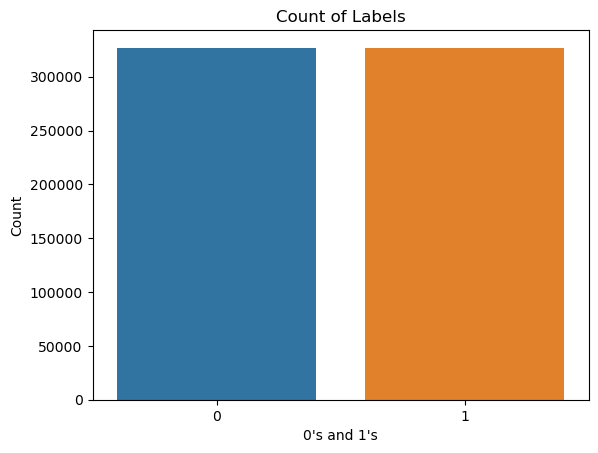

In [32]:
sns.countplot(x='target', data=df)
plt.title("Count of Labels")
plt.xlabel("0's and 1's")
plt.ylabel("Count")
plt.show()

In [33]:
df_Z.shape, df_O.shape

((327000, 10), (326689, 10))

In [34]:
df['target'].value_counts()

0    327000
1    326689
Name: target, dtype: int64

In [28]:
df.corr()

,X,Y,Z,BVP,EDA,HR,INITIAL,INTERVAL,TEMP,target
X,1.000000,0.039912,0.230240,0.029355,-0.018480,0.115840,0.081937,-0.141620,-0.007629,0.383534
Y,0.039912,1.000000,-0.033246,0.011275,-0.059021,-0.024490,-0.030863,0.012174,0.044532,0.155909
Z,0.230240,-0.033246,1.000000,0.021499,-0.026015,-0.077803,0.039261,0.111382,-0.149165,0.372378
BVP,0.029355,0.011275,0.021499,1.000000,-0.003459,-0.005227,-0.001024,0.003317,-0.008183,0.354690
EDA,-0.018480,-0.059021,-0.026015,-0.003459,1.000000,0.060459,-0.115011,-0.108233,0.197744,-0.021482
HR,0.115840,-0.024490,-0.077803,-0.005227,0.060459,1.000000,0.061157,-0.262244,0.160298,-0.000981
INITIAL,0.081937,-0.030863,0.039261,-0.001024,-0.115011,0.061157,1.000000,0.095817,0.061155,-0.029268
INTERVAL,-0.141620,0.012174,0.111382,0.003317,-0.108233,-0.262244,0.095817,1.000000,-0.174466,0.014690
TEMP,-0.007629,0.044532,-0.149165,-0.008183,0.197744,0.160298,0.061155,-0.174466,1.000000,-0.070596
target,0.383534,0.155909,0.372378,0.354690,-0.021482,-0.000981,-0.029268,0.014690,-0.070596,1.000000


In [29]:
df.corr().transpose()

,X,Y,Z,BVP,EDA,HR,INITIAL,INTERVAL,TEMP,target
X,1.000000,0.039912,0.230240,0.029355,-0.018480,0.115840,0.081937,-0.141620,-0.007629,0.383534
Y,0.039912,1.000000,-0.033246,0.011275,-0.059021,-0.024490,-0.030863,0.012174,0.044532,0.155909
Z,0.230240,-0.033246,1.000000,0.021499,-0.026015,-0.077803,0.039261,0.111382,-0.149165,0.372378
BVP,0.029355,0.011275,0.021499,1.000000,-0.003459,-0.005227,-0.001024,0.003317,-0.008183,0.354690
EDA,-0.018480,-0.059021,-0.026015,-0.003459,1.000000,0.060459,-0.115011,-0.108233,0.197744,-0.021482
HR,0.115840,-0.024490,-0.077803,-0.005227,0.060459,1.000000,0.061157,-0.262244,0.160298,-0.000981
INITIAL,0.081937,-0.030863,0.039261,-0.001024,-0.115011,0.061157,1.000000,0.095817,0.061155,-0.029268
INTERVAL,-0.141620,0.012174,0.111382,0.003317,-0.108233,-0.262244,0.095817,1.000000,-0.174466,0.014690
TEMP,-0.007629,0.044532,-0.149165,-0.008183,0.197744,0.160298,0.061155,-0.174466,1.000000,-0.070596
target,0.383534,0.155909,0.372378,0.354690,-0.021482,-0.000981,-0.029268,0.014690,-0.070596,1.000000


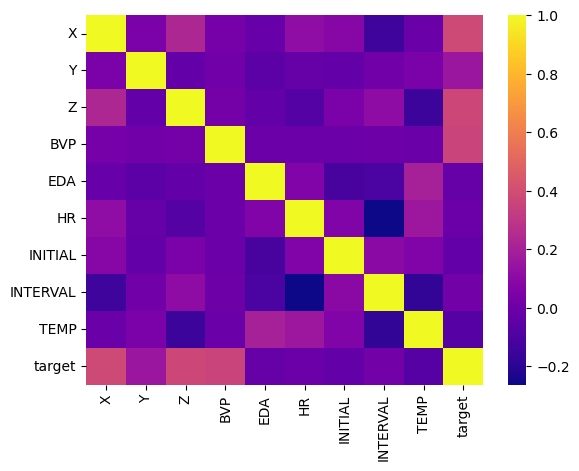

In [30]:
sns.heatmap(df.corr().transpose(), cmap='plasma')
plt.show()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653689 entries, 0 to 653688
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   X         653689 non-null  float64
 1   Y         653689 non-null  float64
 2   Z         653689 non-null  float64
 3   BVP       653689 non-null  float64
 4   EDA       653689 non-null  float64
 5   HR        653689 non-null  float64
 6   INITIAL   653689 non-null  float64
 7   INTERVAL  653689 non-null  float64
 8   TEMP      653689 non-null  float64
 9   target    653689 non-null  int32  
dtypes: float64(9), int32(1)
memory usage: 47.4 MB


## This code is performing several steps to create and train an LSTM (Long Short-Term Memory) model for binary classification. First, it imports the StandardScaler class from the sklearn.preprocessing module and uses it to normalize the input data in a pandas DataFrame called "df". This step scales the data so that each feature has a mean of 0 and a standard deviation of 1, making it easier for the model to learn from. Then, it splits the data into training and testing sets using the train_test_split function from the sklearn.model_selection module. The X variable is assigned the features from the DataFrame, except for the last column, which contains the target variable. The y variable is assigned the target variable. Next, the data is converted to arrays using the numpy module. The training and testing arrays are then reshaped into the input format required for an LSTM model, which expects a 3D input shape of (samples, timesteps, features). The LSTM layer is added to the Sequential model, along with a Dense output layer with a sigmoid activation function. Finally, the model is compiled with binary cross-entropy loss, the Adam optimizer, and accuracy as the evaluation metric. The model is trained using the fit method, with the training data, validation data, and other hyperparameters such as the number of epochs and batch size specified. After training, the model is ready to make predictions on new data.

In [35]:
from sklearn.preprocessing import StandardScaler

# Normalize the data in df
scaler = StandardScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X = df[df.columns[:-1]]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert the data to arrays
import numpy as np

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define and train the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
8172/8172 [==============================] - 31s 4ms/step - loss: 0.1381 - accuracy: 0.9438 - val_loss: 0.0613 - val_accuracy: 0.9778
Epoch 2/10
8172/8172 [==============================] - 31s 4ms/step - loss: 0.0485 - accuracy: 0.9825 - val_loss: 0.0409 - val_accuracy: 0.9846
Epoch 3/10
8172/8172 [==============================] - 31s 4ms/step - loss: 0.0354 - accuracy: 0.9872 - val_loss: 0.0323 - val_accuracy: 0.9886
Epoch 4/10
8172/8172 [==============================] - 31s 4ms/step - loss: 0.0294 - accuracy: 0.9895 - val_loss: 0.0278 - val_accuracy: 0.9899
Epoch 5/10
8172/8172 [==============================] - 32s 4ms/step - loss: 0.0256 - accuracy: 0.9910 - val_loss: 0.0243 - val_accuracy: 0.9915
Epoch 6/10
8172/8172 [==============================] - 31s 4ms/step - loss: 0.0230 - accuracy: 0.9919 - val_loss: 0.0227 - val_accuracy: 0.9919
Epoch 7/10
8172/8172 [==============================] - 33s 4ms/step - loss: 0.0210 - accuracy: 0.9925 - val_loss: 0.0207 - val_ac

<Axes: >

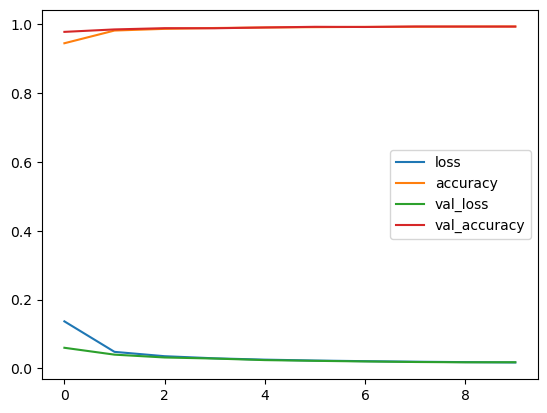

In [19]:
pd.DataFrame(model.history.history).plot()

In [21]:
from sklearn.metrics import accuracy_score
# evaluate the model on the testing data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

Accuracy score: 0.9936208294451498
